## Imports

In [3]:
try:
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt
    from lib.lib_utils import Utils
    import seaborn as sns
    from lib.lib_defect_analysis import Features
    from tqdm import tqdm
    
except Exception as e:
    print(f"Some module are missing: {e}\n")

data_path = Path().resolve().joinpath("data")
xyz_files_path = data_path.joinpath("xyz_files")
yolo_model_path = data_path.joinpath("models","best_100_campioni_new.pt")
images_path = data_path.joinpath("images")
crops_path = data_path.joinpath("crops")

## Generate images from xyz files

In [ ]:
Utils.from_xyz_to_png(
    xyz_files_path, 
    images_path, 
    items=2000)

## YOLO inference to generate binary crops

In [ ]:
Utils.generate_yolo_crops(
    images_path,
    crops_path,
    yolo_model_path,
    binary_mask=True,
)

## Features extraction and dataframe generation

In [4]:

images = [
    f for f in crops_path.iterdir() if f.suffix.lower() in Features.IMAGE_EXTENSIONS
]

features = {}

for image in tqdm(images):
    if len(features) == 0:
        keys_list = list(features.keys())
        df = pd.DataFrame(columns=keys_list)
    else:
        features.clear()

    name = image.stem.split("_crop")[0]

    with open(str(xyz_files_path.joinpath(f"{name}.xyz")), "r") as file:
        first_line = file.readline()
    n_atoms = int(first_line.strip())

    features.update({"file_name": name})
    features.update({"n_atoms": n_atoms})

    shape_features = Features.extract_shape_features(image, grayscale=True)
    if shape_features is not None:
        features.update(shape_features)

    new_row = pd.Series(features)
    df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

grouped_df = df.groupby("file_name").agg(
    {
        "n_atoms": "first",
        "area": "sum",
        "num_pixels": "sum",
        "perimeter": "sum",
        "circularity": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
        "solidity": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
        "compactness": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
        "feret_diameter": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
        "eccentricity": lambda x: (x * df.loc[x.index, "area"]).sum() / df.loc[x.index, "area"].sum(),
    }
).reset_index()

original_df = pd.read_csv(
    xyz_files_path.joinpath("dataset_graphene.csv")
)

energy_dict = original_df.set_index("file_name")["total_energy"].to_dict()

# Aggiunta della colonna total_energy al primo dataframe
grouped_df["total_energy"] = grouped_df["file_name"].map(energy_dict)
grouped_df["energy_per_atom"] = grouped_df["total_energy"] / grouped_df["n_atoms"]

grouped_df.to_csv(
    data_path.joinpath("features.csv"), index=False
)

100%|██████████| 3309/3309 [00:01<00:00, 1866.80it/s]


## Plot correlations

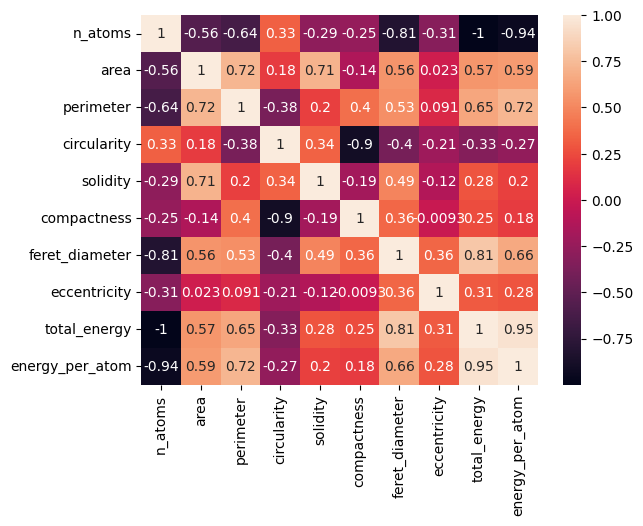

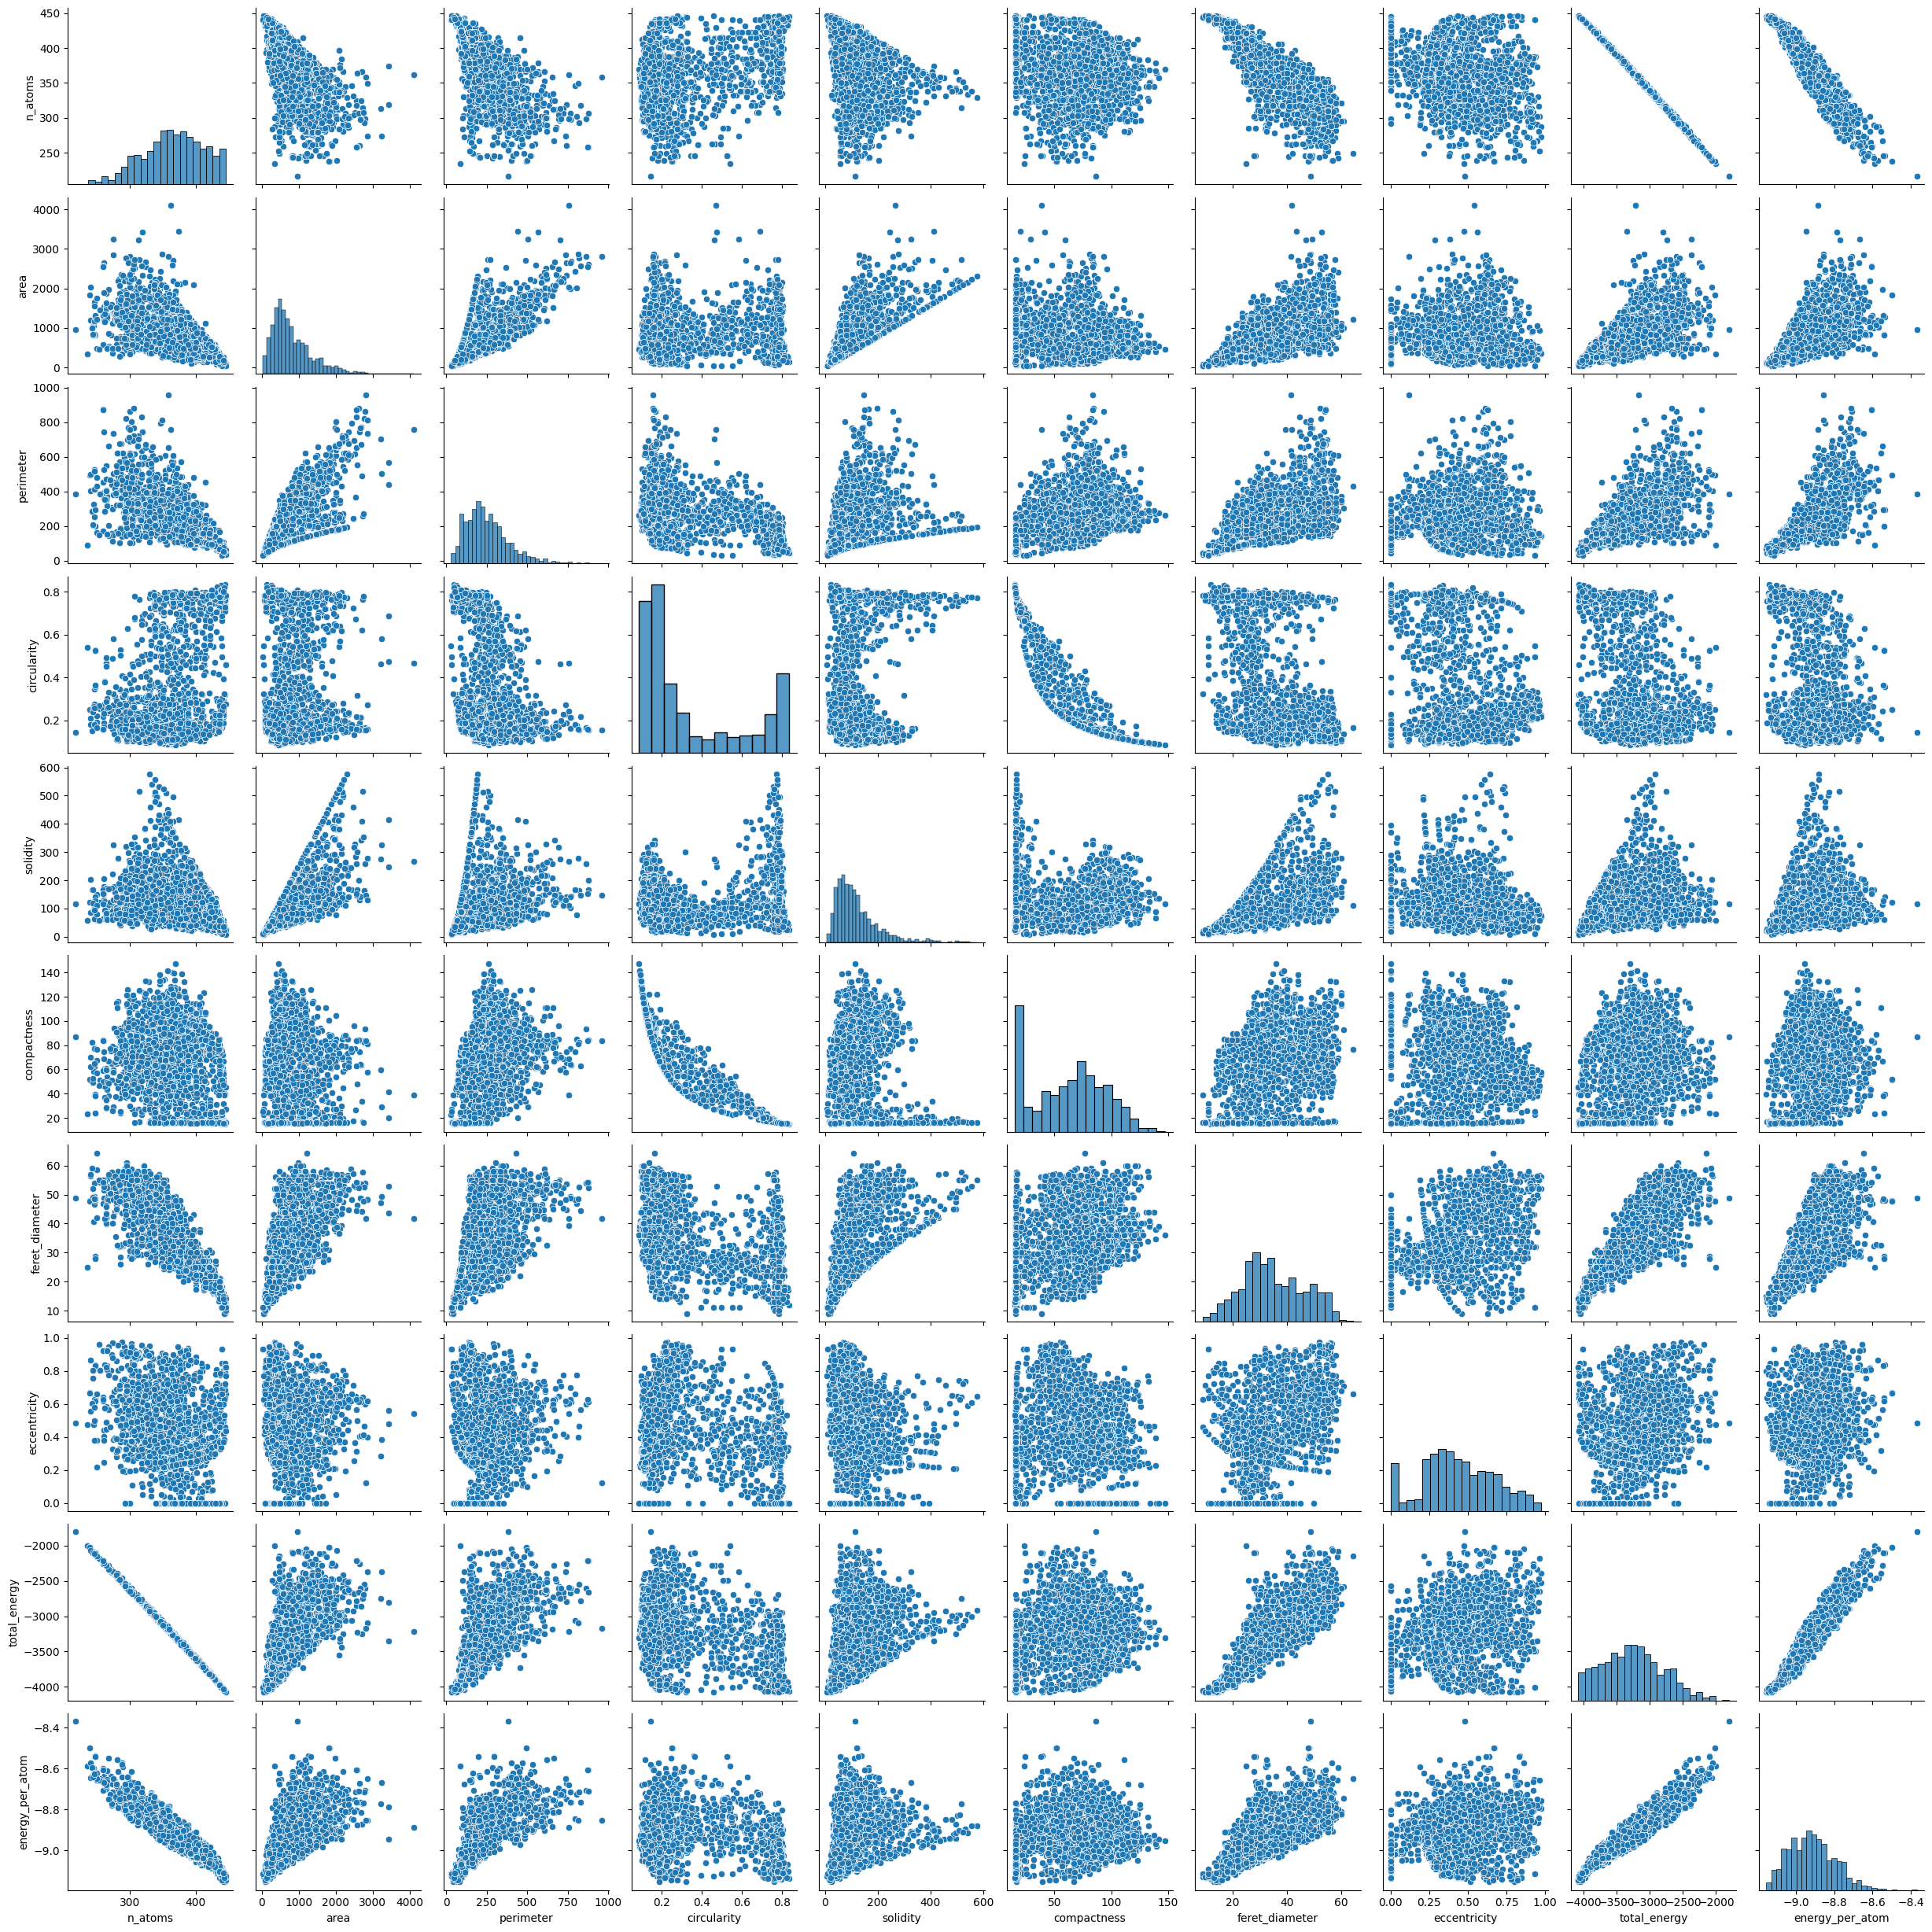

In [4]:
grouped_df = pd.read_csv(data_path.joinpath("features.csv"))
columns_to_drop =["file_name","num_pixels"]
merged_df = grouped_df.drop(columns_to_drop, axis=1)

# stampo heatmap 
corr = merged_df.corr()
sns.heatmap(corr, annot=True)

# stampo basic correlogram
sns.pairplot(merged_df)
plt.show()

## Total energy prediction

In [5]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn import ensemble
    from sklearn.inspection import permutation_importance
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    import scipy
    
except Exception as e:
    print(f"Some module are missing: {e}\n")

## Data preparation

In [11]:

features_list = [ "area", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]

X = grouped_df[features_list].values

y = grouped_df["total_energy"].values.flatten() #array con tutti i valori raget total_energy

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

scaler2 = MinMaxScaler()
y_norm = scaler2.fit_transform(y.reshape(-1, 1))

## Split dataset and set hyperparameters

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)

params = {
    "n_estimators": 500,
    "max_depth": 20,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

## Set regressor and loss function

In [13]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 39222.1478


## Deviance

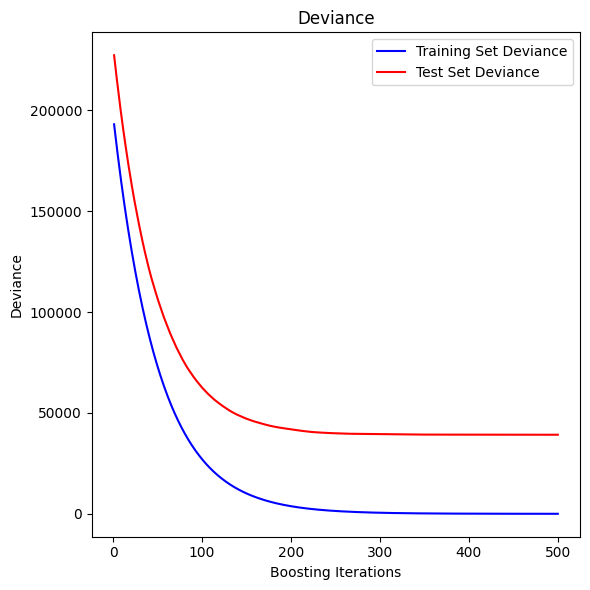

In [14]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Features importance

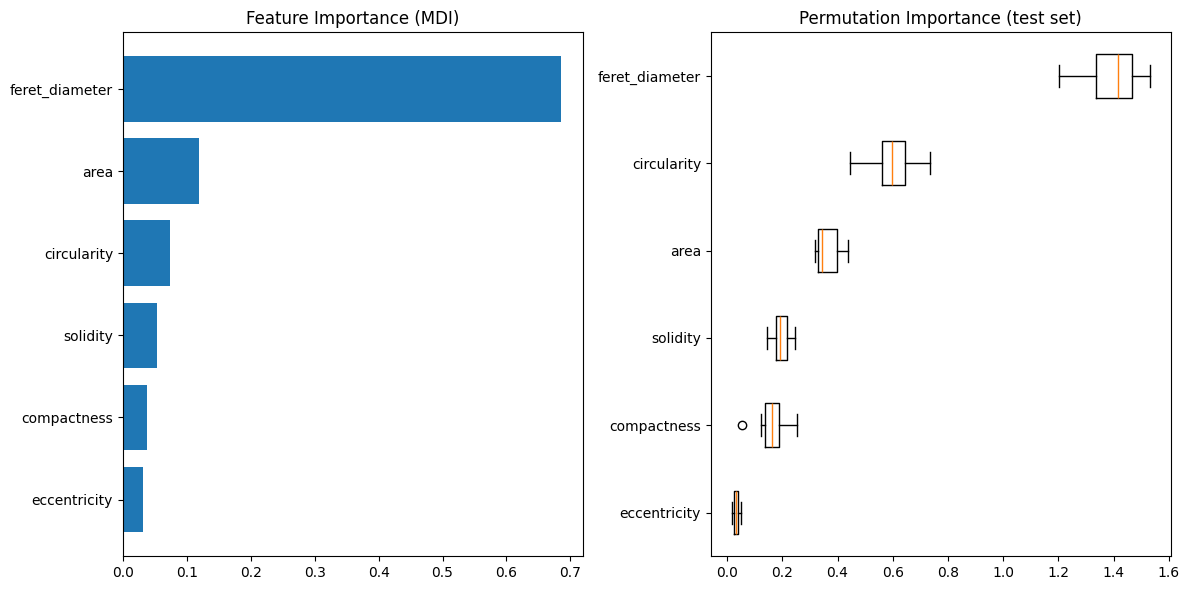

In [15]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_list)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features_list)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()  
plt.show()

## Fit curve

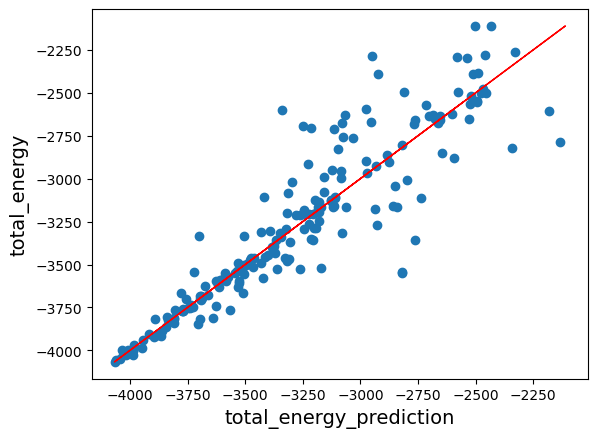

In [16]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test,  color='red', linewidth=1)

plt.xlabel("total_energy_prediction", fontsize=14)
plt.ylabel("total_energy", fontsize = 14)
plt.show()

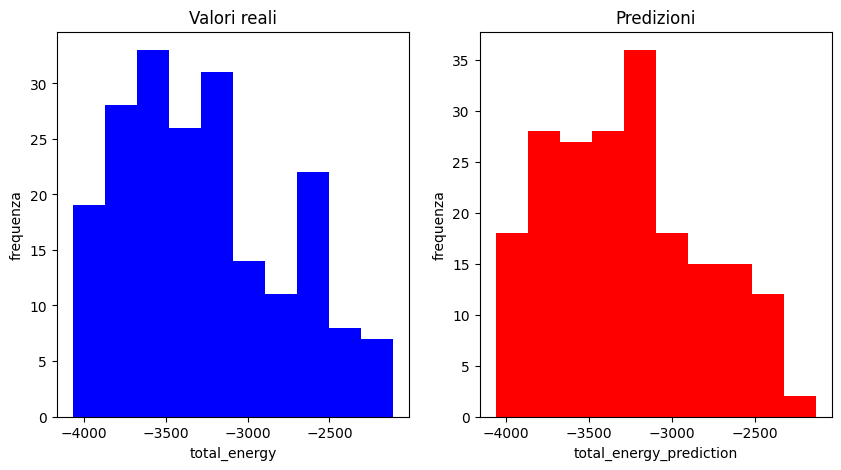

In [17]:
# Crea la figura e i due assi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Istogramma 1
# ax1.hist(y_test, bins=5, weights=y_test, color='blue')
ax1.hist(y_test, bins=10, color='blue')

ax1.set_xlabel('total_energy')
ax1.set_ylabel('frequenza')
ax1.set_title('Valori reali')

# Istogramma 2
# ax2.hist(y_pred, bins=5, weights=y_pred, color='red')
ax2.hist(y_pred, bins=10, color='red')
ax2.set_xlabel('total_energy_prediction')
ax2.set_ylabel('frequenza')
ax2.set_title('Predizioni')

# Mostra il grafico
plt.show()

In [18]:
res = scipy.stats.ttest_ind(y_test, y_pred, equal_var=True)

display(res)

TtestResult(statistic=0.15297513790058204, pvalue=0.8784957982561685, df=396.0)

## Predictions - Real Target Values

In [19]:
print("Target total_energy: ")
print(y_test[1:10])
print("Predicted total_energy: ")
print(reg.predict(X_test[1:10]))
print("Error: ")
print(y_test[1:10]-reg.predict(X_test[1:10]))

Target total_energy: 
[    -2287.7     -3205.8     -4004.4     -3304.3     -3458.6     -3804.1     -3900.5     -3315.3     -4056.3]
Predicted total_energy: 
[    -2951.5     -3250.7     -3987.5     -3391.8     -3415.9     -3839.2     -3875.7     -3078.4     -4061.3]
Error: 
[     663.77       44.94     -16.811      87.555     -42.703      35.105     -24.771     -236.88      5.0276]


## R^2 Score

In [20]:
reg.score(X_test, y_test)

0.8303351900944411